# Image Classification with Vision Transformers

```{article-info}
:avatar: https://avatars.githubusercontent.com/u/25820201?v=4
:avatar-link: https://github.com/PhotonicGluon/
:author: "[Ryan Kan](https://github.com/PhotonicGluon/)"
:date: "Jul 10, 2024"
:read-time: "{sub-ref}`wordcount-minutes` min read"
```

*This notebook is largely inspired by the Keras code example [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/) by [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/).*

<center>
    <img alt="CIFAR-10 Dataset" style="width: 50%" src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png">
</center>

In this example, we will classify images in the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using the [Vision Transformer (ViT)](https://arxiv.org/pdf/2010.11929v2) model by Alexey Dosovitskiy et al. using Keras-MML layers.

:::{important}
We will be using some plotting utilities for this notebook. Run the command below to install them, then reload the kernel.
:::

In [1]:
%pip install matplotlib~=3.9.0 seaborn~=0.13.2

Set up plotting utilities.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

:::{note}
We will use the `jax` backend for faster execution of the code. Feel free to ignore the cell below.
:::

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"

## Preparing the Data

Conveniently, the CIFAR-10 dataset is already available in Keras, so we just need to load it from there.

In [4]:
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

:::{note}
For faster execution of the code, we will only use 1% of the full dataset (both training and testing). In practice the full training/testing dataset should be used.
:::

In [5]:
DEMO_SPLIT = 0.01

x_train = x_train[: int(x_train.shape[0] * DEMO_SPLIT)]
y_train = y_train[: int(y_train.shape[0] * DEMO_SPLIT)]
x_test = x_test[: int(x_test.shape[0] * DEMO_SPLIT)]
y_test = y_test[: int(y_test.shape[0] * DEMO_SPLIT)]

Let's take a look at the shapes of the downloaded arrays.

In [6]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (500, 32, 32, 3) - y_train shape: (500, 1)
x_test shape: (100, 32, 32, 3) - y_test shape: (100, 1)


The CIFAR-10 dataset contains 10 distinct classes. Each image in the dataset is $32 \times 32$ with 3 channels, meaning that the `INPUT_SHAPE` for our model is `(32, 32, 3)`.

In [7]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

For actual processing, let's resize the images so that we get more *patches* that the ViT learns from.

In [8]:
IMAGE_SIZE = 72

To improve the performance of the model, let's perform some data augmentation on the images.

In [9]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train)


## Model Creation

In [10]:
import keras_mml

Let's define the size of the patches that we want.

In [11]:
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

Let's display the patches for a sample image. This is done through the `Patches` layer.

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


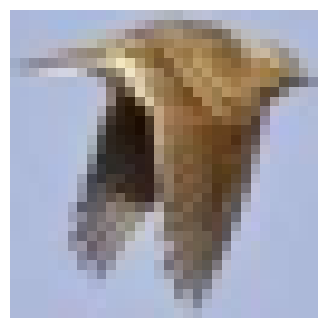

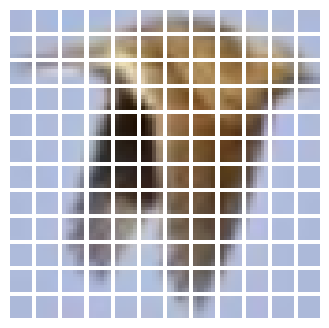

In [12]:
import numpy as np
from keras import ops

plt.figure(figsize=(4, 4))
image = x_train[123]  # Just as an example
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)
patches = keras_mml.layers.Patches(PATCH_SIZE)(resized_image) #  Patch generation layer
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))  # Make it back into RGB
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

To generate the embeddings for the patches, we can use the `PatchEmbedding` layer that was also included in Keras-MML. This layer will encode each patch as a `PROJECTION_DIM`-dimensional vector that can be used in the transformer block that is incoming.

In [13]:
PROJECTION_DIM = 64

We are now ready to create the full model. We will use the `TRANSFORMER_LAYERS` hyperparameter to specify the number of transformer blocks to use in the ViT.

In [14]:
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4

In [15]:
model = keras.models.Sequential()
model.add(layers.Input(shape=INPUT_SHAPE))

# Augment the data
model.add(data_augmentation)

# Create patches
model.add(keras_mml.layers.Patches(PATCH_SIZE))

# Create patch embeddings
model.add(keras_mml.layers.PatchEmbedding(NUM_PATCHES, PROJECTION_DIM, with_positions=True))

# Use multiple transformer blocks
for _ in range(TRANSFORMER_LAYERS):
    model.add(keras_mml.layers.TransformerBlockMML(PROJECTION_DIM, PROJECTION_DIM * 2, NUM_HEADS, rate=0.1))

# Normalize, flatten, and dropout
model.add(layers.LayerNormalization(epsilon=1e-6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

# Add SwiGLUMML for final classification fine tuning
model.add(keras_mml.layers.DenseMML(1024))
model.add(keras_mml.layers.DenseMML(256))

# Final classification head
model.add(layers.Dense(NUM_CLASSES))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 72, 72, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patches_1 (Patches)                  │ (None, 144, 108)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding (PatchEmbedding)     │ (None, 144, 64)             │          31,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml                │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_1              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_2              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_3              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_4              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_5              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_6              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_mml_7              │ (None, 144, 64)             │          69,440 │
│ (TransformerBlockMML)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 144, 64)             │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_mml_17 (DenseMML)              │ (None, 1024)                │       9,447,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_mml_18 (DenseMML)              │ (None, 256)                 │         263,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           2,5

 Total params: 10,300,817 (39.29 MB)

 Trainable params: 10,300,810 (39.29 MB)

 Non-trainable params: 7 (28.00 B)

We compile the model, using the Adam optimizer with weight decay (i.e., `AdamW`) and aiming to minimize the sparse categorical crossentropy. We monitor the accuracy and top-5 accuracy scores.

In [16]:
from keras import optimizers, losses, metrics

model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        metrics.SparseCategoricalAccuracy(name="acc"),
        metrics.SparseTopKCategoricalAccuracy(5, name="top_5_acc"),
    ],
)

We will also regularly save the weights of the model, and keeping only the weights that make the model score the highest in the validation accuracy.

In [17]:
from keras import callbacks

checkpoint_filepath = "misc/vit/checkpoint.weights.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

We can now train the model.

In [18]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=5,  # We use 5 epochs here for demonstration purposes. Use somewhere around 100 epochs for real training
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 235s 15s/step - acc: 0.1486 - loss: 4.6825 - top_5_acc: 0.5412 - val_acc: 0.2000 - val_loss: 4.3141 - val_top_5_acc: 0.7000
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 200s 13s/step - acc: 0.2015 - loss: 3.5198 - top_5_acc: 0.7247 - val_acc: 0.2600 - val_loss: 2.3203 - val_top_5_acc: 0.6400
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 163s 11s/step - acc: 0.2339 - loss: 2.2447 - top_5_acc: 0.7672 - val_acc: 0.1800 - val_loss: 2.2486 - val_top_5_acc: 0.7400
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 205s 14s/step - acc: 0.2787 - loss: 1.9467 - top_5_acc: 0.8139 - val_acc: 0.3600 - val_loss: 2.0642 - val_top_5_acc: 0.8200
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 167s 11s/step - acc: 0.3966 - loss: 1.7190 - top_5_acc: 0.8764 - val_acc: 0.2800 - val_loss: 2.1091 - val_top_5_acc: 0.8200


Let's see how good the model is on the test dataset.

In [19]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")
print(f"Test top 5 accuracy: {top_5_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - acc: 0.3947 - loss: 1.8359 - top_5_acc: 0.8494
Test accuracy: 38.00%
Test top 5 accuracy: 85.00%


What does the model's history look like?

In [20]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

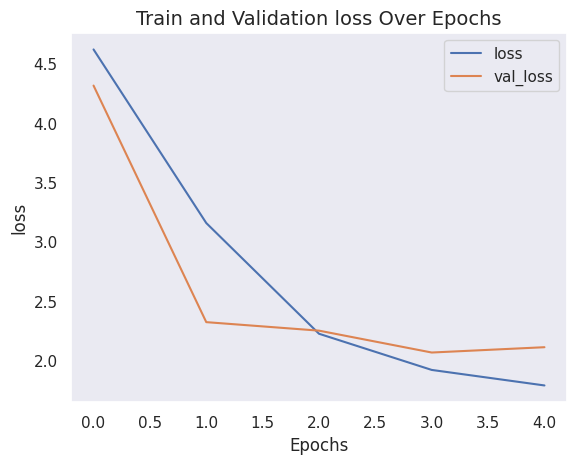

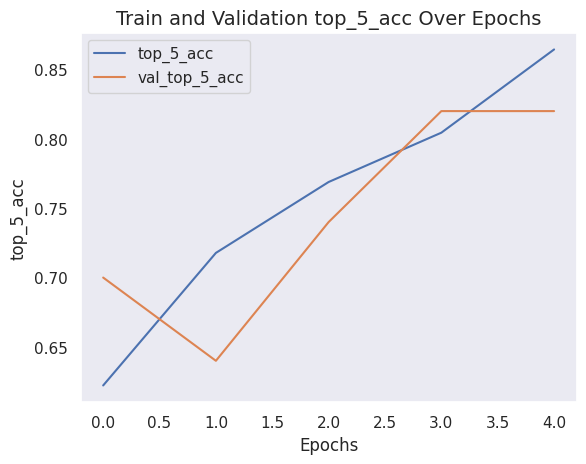

In [21]:
plot_history("loss")
plot_history("top_5_acc")

## Conclusion

After 5 epochs, the ViT model achieves around 38% accuracy and 85% top-5 accuracy on the test data. These are not competitive results on the CIFAR-10 dataset. Certainly, this could be due to the small sample used for training in this demonstration, but the more important reason is that this is not how the ViT paper performs the training.

The state of the art results reported in the paper are achieved by pre-training the ViT model using the [JFT-300M dataset](https://paperswithcode.com/dataset/jft-300m), then fine-tuning it on the target dataset (i.e. the CIFAR-10 dataset). In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

Regardless, we used mostly matmul-less layers in this model, and we still achieved commendable results.